# eReefs dataset cross section

We have seen how to make a map of the eReefs dataset. In some occasions, we might be interested in looking at the evolution of a specific parameter over a cross-section. Here we will see how this can be simply done with the librairies we have seen so far...

## Load the required Python libraries

First of all, load the necessary libraries:

+ numpy
+ matplotlib
+ cartopy

In [1]:
import os
import numpy as np

import datetime as dt

import netCDF4
from netCDF4 import Dataset, num2date

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

## Connect to the OPeNDAP endpoint for a specified month. 


We query the server based on the OPeNDAP URL for a specific file. We will use the data from the [AIMS server](http://thredds.ereefs.aims.gov.au/thredds/catalog.html). 


- **gbr4**: we use the 4km model and daily data for a month specified

In [4]:
month = 4
year = 2019

netCDF_datestr = str(year)+'-'+format(month, '02')
print('File chosen time interval:',netCDF_datestr)

# GBR4 HYDRO
#inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"+netCDF_datestr+".nc"

# GBR4 BIO
inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"+netCDF_datestr+".nc"

File chosen time interval: 2019-04


We now load the dataset within the Jupyter environment...

In [5]:
nc_data = Dataset(inputFile, 'r')

print('Get the list of variable in the file:')
print(list(nc_data.variables.keys()))

ncdata = nc_data.variables

Get the list of variable in the file:
['alk', 'BOD', 'Chl_a_sum', 'CO32', 'DIC', 'DIN', 'DIP', 'DOR_C', 'DOR_N', 'DOR_P', 'Dust', 'EFI', 'FineSed', 'Fluorescence', 'HCO3', 'Kd_490', 'MPB_Chl', 'MPB_N', 'Mud-carbonate', 'Mud-mineral', 'Nfix', 'NH4', 'NO3', 'omega_ar', 'Oxy_sat', 'Oxygen', 'P_Prod', 'PAR', 'PAR_z', 'pco2surf', 'PH', 'PhyL_Chl', 'PhyL_N', 'PhyS_Chl', 'PhyS_N', 'PhyS_NR', 'PIP', 'salt', 'TC', 'temp', 'TN', 'TP', 'Tricho_Chl', 'Tricho_N', 'Z_grazing', 'ZooL_N', 'ZooS_N', 'zc', 'time', 'latitude', 'longitude', 'CH_N', 'CS_bleach', 'CS_Chl', 'CS_N', 'EpiPAR_sg', 'eta', 'MA_N', 'MA_N_pr', 'month_EpiPAR_sg', 'R_400', 'R_410', 'R_412', 'R_443', 'R_470', 'R_486', 'R_488', 'R_490', 'R_510', 'R_531', 'R_547', 'R_551', 'R_555', 'R_560', 'R_590', 'R_620', 'R_640', 'R_645', 'R_665', 'R_667', 'R_671', 'R_673', 'R_678', 'R_681', 'R_709', 'R_745', 'R_748', 'R_754', 'R_761', 'R_764', 'R_767', 'R_778', 'Secchi', 'SG_N', 'SG_N_pr', 'SG_shear_mort', 'SGD_N', 'SGD_N_pr', 'SGD_shear_mort', 'SG

To get information for a specific variables, we can use the following:

In [6]:
ncdata['alk']

<class 'netCDF4._netCDF4.Variable'>
float32 alk(time, k, latitude, longitude)
    coordinates: time zc latitude longitude
    short_name: alk
    units: mmol m-3
    long_name: Total alkalinity
    _ChunkSizes: [  1   1 133 491]
unlimited dimensions: time
current shape = (30, 17, 723, 491)
filling off

In [7]:
ncdata['alk'].long_name

'Total alkalinity'

In [8]:
ncdata['alk'].units

'mmol m-3'

## Load variables

We then load the longitude/latidude in the Jupyter environment:

In [29]:
# Starting with the spatial domain
lat = ncdata['latitude'][:]
lon = ncdata['longitude'][:]

print('eReefs model spatial extent:\n')
print(' - Longitudinal extent:',lon.min(),lon.max())
print(' - Latitudinal extent:',lat.min(),lat.max())

eReefs model spatial extent:

 - Longitudinal extent: 142.168788 156.868788
 - Latitudinal extent: -28.696022 -7.036022


We can also check the temporal and z-coordinate extent of the chosem dataset:

In [30]:
# Get time span of the dataset
time_var = ncdata['time']

# Starting time
dtime = netCDF4.num2date(time_var[0],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print(' - start time: ',daystr,'\n')

# Ending time
dtime = netCDF4.num2date(time_var[-1],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print(' - end time: ',daystr,'\n')

ntime = len(time_var)
print(' - Number of time steps',ntime,'\n')

zc = ncdata['zc'][:]
nlay = len(zc)

print(' - Number of vertical layers',nlay)

 - start time:  2019-Apr-01 02:00 

 - end time:  2019-Apr-30 02:00 

 - Number of time steps 30 

 - Number of vertical layers 17


## Cross-section

Let's make 2 cross-sections along specific latitude and longitude coordinates.

- chosen latitude: **11 S** 
- chosen longitude: **148 E** 

The AIMS dataset has been resample on a regular grid, so first we find the closest point to the desired latitude. 

In [32]:
def find_nearest(array, value):
    '''
    Find index of nearest value in a numpy array
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

We will then extract all the point along this latitude:

In [41]:
def eReefs_cross_data(data, tstep, latID=None, lonID=None):
    
    '''
    Extract specified dataset along a given latitude or longitude.
    
    args:
    - dataname: specified variable name 
    - latID: latitudinal index
    - lonID: longitudinal index
    '''
    
    # Get data
    if latID is not None:
        return data[tstep, :, latID, :]
    elif lonID is not None:
        return data[tstep, :, :, lonID]

Now we will call these functions...

In [42]:
selectedLatIndex = find_nearest(lat, -11.)
selectedLonIndex = find_nearest(lon, 148)

selectedTimeIndex = 29   
selectedVariable = 'alk' 

alkLat = eReefs_cross_data(ncdata[selectedVariable], selectedTimeIndex,
                           selectedLatIndex, None)
alkLon = eReefs_cross_data(ncdata[selectedVariable], selectedTimeIndex,
                           None, selectedLonIndex)

In [43]:
print(' ')
print('Data range: ')
print(np.nanmin(alkLat),np.nanmax(alkLat))

 
Data range: 
2183.413 2270.2312


We then define the plotting function:

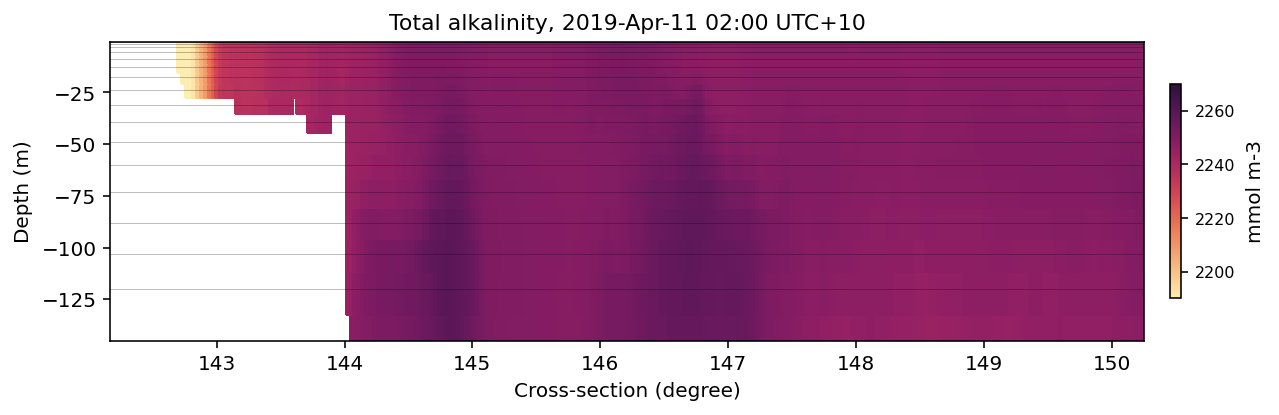

<Figure size 432x288 with 0 Axes>

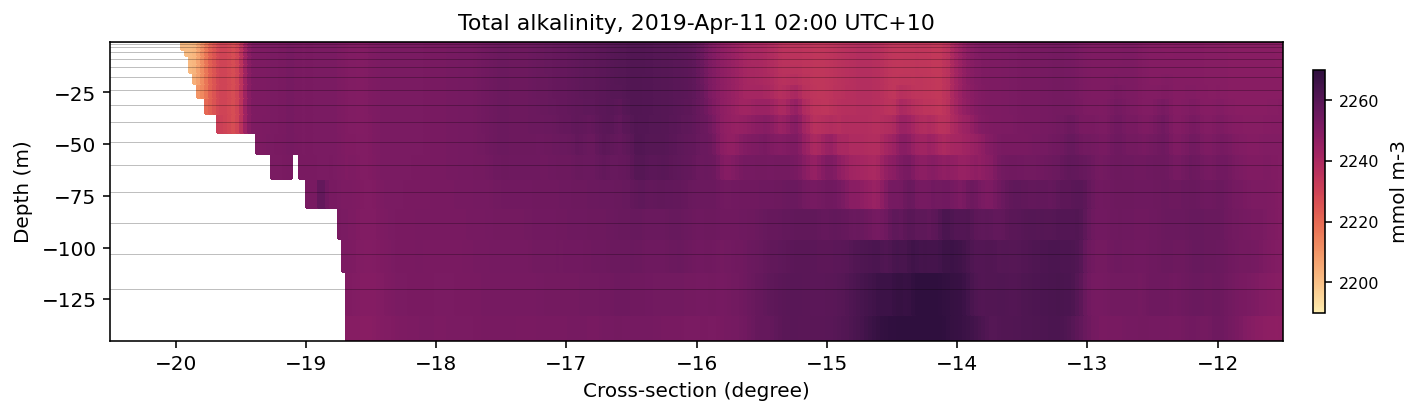

<Figure size 432x288 with 0 Axes>

In [77]:
def plot_cross_section(ncdata, tstep, dataname, xdata, ydata, color, size, fname, 
                       xext=None, dext=None, show=False, save=False):
    '''
    This function plots a cross-section for a specified time interval along a given latitude or longitude.
    
    args:
    
    - ncdata: netcdf dataset
    - tstep: specified time index
    - dataname: specified variable name 
    - xdata: x-axis along the desired cross-section
    - ydata: data along the desired cross-section
    - xext: extent to plot for the x-axis
    - dext: data minimum and maximum values for plotting
    - color: colormap to use for the plot (here one can use the cmocean library: https://matplotlib.org/cmocean/#installation)
    - size: figure size  
    - fname: figure name when saved on disk, it is worth noting that the specified time index will be automatically added
    - show: set to True when the map is shown in the jupyter environment directly 
    - save: set to True to save figure on disk
    '''
    fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

    ax = plt.axes()
    plt.xlabel('Cross-section (degree)')
    plt.ylabel('Depth (m)')

    if xext is not None:
        plt.xlim(xext[0], xext[1])
        
    zc = ncdata['zc'][:]
    plt.ylim(zc.min(), zc.max())

    if dext is not None:
        cm = plt.pcolormesh(xdata, zc, ydata[:,:],  
                       cmap = color,  
                       vmin = dext[0],  
                       vmax = dext[1], 
                       edgecolors = 'face', 
                       shading ='auto') 
    else:
        cm = plt.pcolormesh(xdata, zc, ydata[:,:],  
                       cmap = color,  
                       edgecolors = 'face', 
                       shading ='auto') 
        
    dtime = netCDF4.num2date(ncdata['time'][tstep],ncdata['time'].units)
    daystr = dtime.strftime('%Y-%b-%d %H:%M')
    plt.title(ncdata[dataname].long_name+', %s UTC+10' % (daystr), fontsize=11);

    # Color bar
    cbar = fig.colorbar(cm, ax=ax, fraction=0.01, pad=0.025)
    cbar.set_label(ncdata[dataname].units, rotation=90, labelpad=5, fontsize=10)
    cbar.ax.tick_params(labelsize=8)
    
    # Get z-coordinate lines
    for k in range(len(zc)):
        plt.plot(xext,[zc[k],zc[k]],lw=0.5,c='k',alpha=0.25)
        
    if show:
        if save:
            plt.savefig(f"{fname}_cross_time{tstep:04}.png",dpi=300, 
                    bbox_inches='tight')
        plt.tight_layout()
        plt.show()
    else:
        plt.savefig(f"{fname}_cross_time{tstep:04}.png",dpi=300, 
                bbox_inches='tight')

    fig.clear()
    plt.close(fig)
    plt.clf()

    return

color = cmocean.cm.matter
fname = 'lat11'
xext = [lon.min(),150.25]
size = (9,3)
    
dext = [2190.,2270.]
plot_cross_section(ncdata, selectedTimeIndex, selectedVariable, lon, alkLat, color, size,  
                   fname, xext, dext, show=True, save=False)

fname = 'lon148'
xext = [-20.5,-11.5]
size = (10,3)
plot_cross_section(ncdata, selectedTimeIndex, selectedVariable, lat, alkLon, color, size, 
                   fname, xext, dext, show=True, save=False)

## Build a function to simplify the process

In [78]:
def eReefs_cross(ncdata, tstep, dataname, color, latVal=None, lonVal=None, size=None, 
                 fname=None, xext=None, dext=None, show=False, save=False):
    '''
    This function plots cross-sections for a specified time interval along a given latitude and/or longitude.

    args:
    
    - ncdata: netcdf dataset
    - tstep: specified time index
    - dataname: specified variable name 
    - color: colormap to use for the plot (here one can use the cmocean library: https://matplotlib.org/cmocean/#installation)
    - latVal: latitude of the desired cross-section
    - lonVal: longitude of the desired cross-section
    - size: figure size
    - fname: figure name when saved on disk, the time step value is automatically added
    - xext: extent to plot for the x-axis for the cross-section     
    - dext: data minimum and maximum values for plotting
    - show: set to True when the map is shown in the jupyter environment directly 
    - save: set to True to save figure on disk
    '''
    
    lat = ncdata['latitude'][:]
    lon = ncdata['longitude'][:]
    
    if latVal is not None:
        LatID = find_nearest(lat, latVal)
        dataLat = eReefs_cross_data(ncdata[dataname], tstep, LatID, None)
        plot_cross_section(ncdata, tstep, dataname, lon, dataLat, color, size,  
                           fname, xext, dext, show, save)
        
    if lonVal is not None:
        LonID = find_nearest(lon, lonVal)
        dataLon = eReefs_cross_data(ncdata[dataname], tstep, None, LonID)
        plot_cross_section(ncdata, tstep, dataname, lat, dataLon, color, size, 
                           fname, xext, dext, show, save)

    return

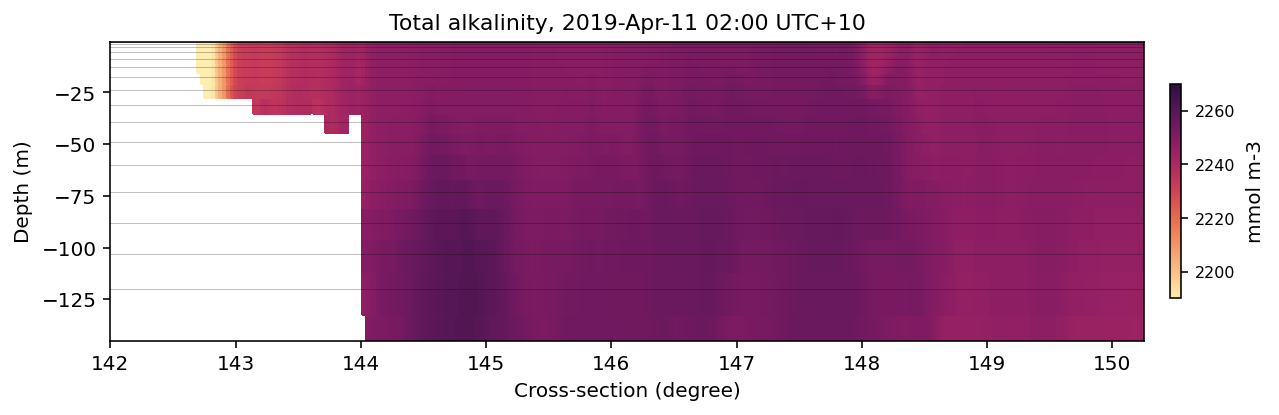

<Figure size 432x288 with 0 Axes>

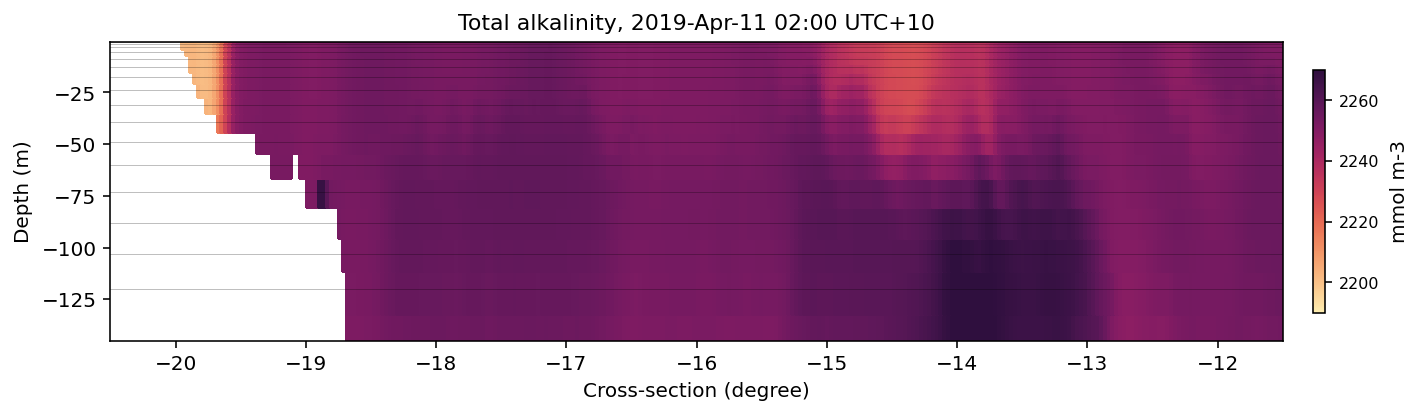

<Figure size 432x288 with 0 Axes>

In [79]:
selectedTimeIndex = 10  
selectedVariable = 'alk' 
color = cmocean.cm.matter

latVal = -11. 
lonVal = 148.

xLon = [142,150.25]
xLat = [-20.5,-11.5]
dext = [2190.,2270.]

fLat = 'lat11'
fLon = 'lon148'

sizeLat = (9,3)
sizeLon = (10,3)

eReefs_cross(ncdata, selectedTimeIndex, selectedVariable, color, 
             latVal, None, sizeLat, fLat, xLon, dext, show=True, 
             save=False)

eReefs_cross(ncdata, selectedTimeIndex, selectedVariable, color, 
             None, lonVal, sizeLon, fLon, xLat, dext, show=True, 
             save=False)